# Notebook

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from src.util import load_star_galaxy_dataset

## Data

Let's first load the dataset.

In [2]:
star_galaxy = load_star_galaxy_dataset()
print(star_galaxy.DESCR)

This is a simple dataset consisting of ~3000 64x64 images of stars and ~1000 images of galaxies. The images were captured by the in-house 1.3m telescope of the observatory situated in Devasthal, Nainital, India.


Now, let's take a peek at some of the images in the dataset.

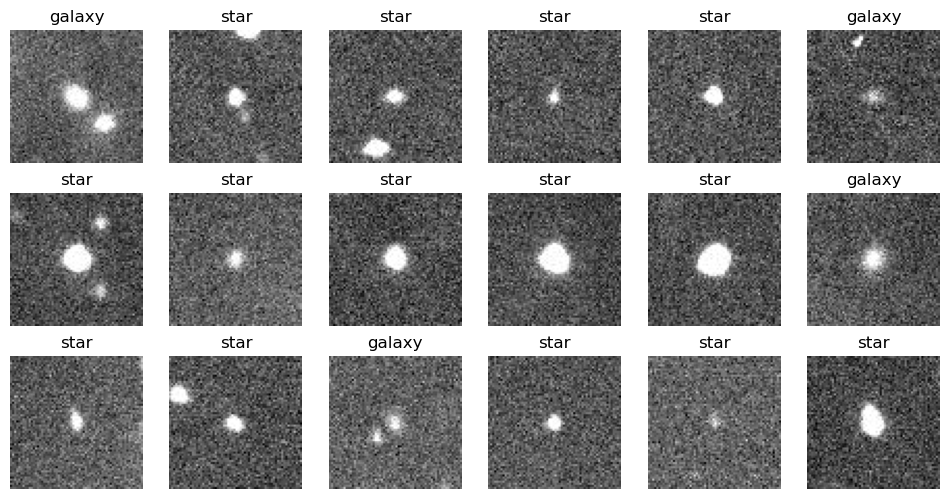

In [3]:
w, h = 6, 3

_, axs_list = plt.subplots(h, w, figsize=(2 * w, 2 * h))

_i = 0
indices = np.random.choice(len(star_galaxy.data), size=(h * w))
for axs in axs_list:
    for ax in axs:
        i = indices[_i]
        ax.axis("off")
        img = star_galaxy.data[i].reshape((64, 64))
        ax.imshow(img, cmap="gray")
        ax.set_title(star_galaxy.target_names[star_galaxy.target[i]])
        _i += 1

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    star_galaxy.data,
    star_galaxy.target,
    test_size=0.3,
)

## KNN
Let's first look at K-Nearest Neighbor classification.

In [5]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=1)
knn_model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [6]:
predictions = knn_model.predict(X_test)

In [7]:
print(
    classification_report(
        y_true=y_test,
        y_pred=predictions,
        target_names=star_galaxy.target_names,
    )
)
C = confusion_matrix(
    y_true=y_test,
    y_pred=predictions,
    normalize="true",
)
print(f"true negatives: {C[0,0]}")
print(f"false negatives: {C[1,0]}")
print(f"true positives: {C[1,1]}")
print(f"false positives: {C[0,1]}")

              precision    recall  f1-score   support

        star       0.81      0.91      0.85       916
      galaxy       0.49      0.29      0.36       280

    accuracy                           0.76      1196
   macro avg       0.65      0.60      0.61      1196
weighted avg       0.73      0.76      0.74      1196

true negatives: 0.9082969432314411
false negatives: 0.7142857142857143
true positives: 0.2857142857142857
false positives: 0.09170305676855896


In [13]:
error_rates = []
k_range = np.arange(1, 35)
for k_neighbors in k_range:
    knn_model = KNeighborsClassifier(n_neighbors=k_neighbors)
    knn_model.fit(X_train, y_train)
    predictions = knn_model.predict(X_test)
    error_rates.append(np.mean(predictions != y_test))

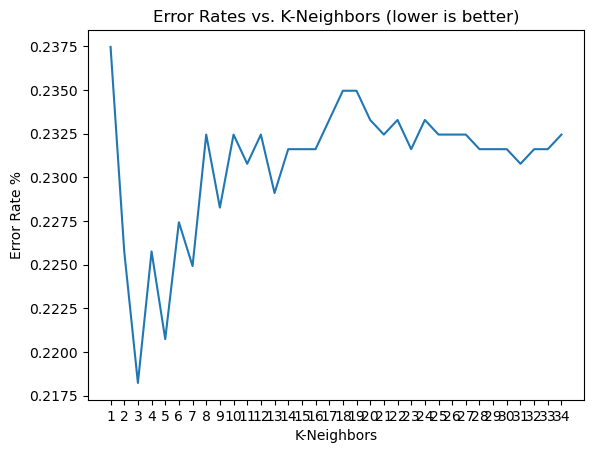

In [14]:
plt.title("Error Rates vs. K-Neighbors (lower is better)")
plt.xlabel("K-Neighbors")
plt.ylabel("Error Rate %")
plt.xticks(k_range)
plt.plot(k_range, error_rates)

In [17]:
i = np.where(error_rates == np.min(error_rates))[0][0]  # index of minimum
min_err = error_rates[i]  # Minimum error rate
k = i + 1                 # K neighbors
print(f"Minimum error rate is {min_err}, with {k} neighbors")
print(f"Average error rate is {np.average(error_rates)}")

Minimum error rate is 0.21822742474916387, with 3 neighbors
Average error rate is 0.23076923076923078
